In [1]:
%load_ext autoreload
%autoreload 2

In [124]:
from collections import Counter
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, space_eval
import matplotlib.pyplot as plt
import mlflow
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler

import tensorflow as ft
from tensorflow import keras
from tensorflow.keras import layers

from xgboost import XGBClassifier

In [125]:
from meli.utils import split_data, split_data_on_index, shap_explain
from meli.plot import (correlation_matrix, 
                       pair_plot,
                       plot_attributes,
                       pair_plot_attributes_target,
                       make_confusion_matrix,
                       xgb_learning_curves)

In [4]:
%matplotlib inline

In [5]:
plt.style.use("seaborn-whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)

In [6]:
df = pd.read_csv("../data/raw/full_devices.csv", 
                 index_col=["device", "date"],
                 parse_dates=["date"],
                 encoding_errors="replace")

In [7]:
df = df.sort_index()

In [8]:
df.head(10)

failure  attribute1  attribute2  attribute3  attribute4  \
device   date                                                                  
S1F01085 2015-01-01        0   215630672          56           0          52   
         2015-01-02        0     1650864          56           0          52   
         2015-01-03        0   124017368          56           0          52   
         2015-01-04        0   128073224          56           0          52   
         2015-01-05        0    97393448          56           0          52   
         2015-01-06        0   128832128          56           0          52   
S1F013BB 2015-05-06        0    14533968           0           0           0   
         2015-05-07        0    46202296           0           0           0   
         2015-05-08        0   214383720           0           0           0   
         2015-05-09        0   243346080           0           0           0   

                     attribute5  attribute6  attribute7  attribute8  \
device   date                                                         
S1F01085 2015-01-01           6      407438           0           0   
         2015-01-02           6      407438           0           0   
         2015-01-03           6      407438           0           0   
         2015-01-04           6      407439           0           0   
         2015-01-05           6      408114           0           0   
         2015-01-06           6      409404           0           0   
S1F013BB 2015-05-06           5      688952           0           0   
         2015-05-07           5      688952           0           0   
         2015-05-08           5      688964           0           0   
         2015-05-09           5      689035           0           0   

                     attribute9  
device   date                    
S1F01085 2015-01-01           7  
         2015-01-02           7  
         2015-01-03           7  
         2015-01-04           7  
         2015-01-05           7  
         2015-01-06           7  
S1F013BB 2015-05-06           0  
         2015-05-07           0  
         2015-05-08           0  
         2015-05-09           0

In [9]:
target = "failure"
test_size = 0.2
random_state = 1

## Index analysis

O índice é composto pelas colunas `device` e `date`. A coluna `date` foi corretamente interpretada como tipo data na leitura do dataframe.

Existe um registro duplicado no índice, este será removido.

In [10]:
df.index.is_unique

False

In [11]:
df.groupby(["device", "date"]).count().sort_values(by=target, ascending=False).head()

failure  attribute1  attribute2  attribute3  attribute4  \
device   date                                                                  
S1F0R4Q8 2015-07-10        2           2           2           2           2   
S1F01085 2015-01-01        1           1           1           1           1   
W1F17DKS 2015-05-05        1           1           1           1           1   
         2015-05-03        1           1           1           1           1   
         2015-05-02        1           1           1           1           1   

                     attribute5  attribute6  attribute7  attribute8  \
device   date                                                         
S1F0R4Q8 2015-07-10           2           2           2           2   
S1F01085 2015-01-01           1           1           1           1   
W1F17DKS 2015-05-05           1           1           1           1   
         2015-05-03           1           1           1           1   
         2015-05-02           1           1           1           1   

                     attribute9  
device   date                    
S1F0R4Q8 2015-07-10           2  
S1F01085 2015-01-01           1  
W1F17DKS 2015-05-05           1  
         2015-05-03           1  
         2015-05-02           1

In [12]:
df.loc[("S1F0R4Q8", "2015-07-10")]

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
date,,,,,,,,,,
2015-07-10,0,192721392,0,0,0,8,213700,0,0,0
2015-07-10,0,192721392,0,0,0,8,213700,0,0,0


In [13]:
df.shape

(124494, 10)

In [14]:
df = df[~df.index.duplicated()]

In [15]:
df.shape

(124493, 10)

In [16]:
df.loc[("S1F0R4Q8", "2015-07-10")]

failure               0
attribute1    192721392
attribute2            0
attribute3            0
attribute4            0
attribute5            8
attribute6       213700
attribute7            0
attribute8            0
attribute9            0
Name: (S1F0R4Q8, 2015-07-10 00:00:00), dtype: int64

## Basic analysis

- Os `dtypes` estão consistentes, vamos apenas converter para `float`
- Não existe missing data

In [17]:
df.value_counts(target)

failure
0    124387
1       106
dtype: int64

In [18]:
df.dtypes

failure       int64
attribute1    int64
attribute2    int64
attribute3    int64
attribute4    int64
attribute5    int64
attribute6    int64
attribute7    int64
attribute8    int64
attribute9    int64
dtype: object

In [19]:
int_cols = [col for col in df.select_dtypes('int64') if col != target]
for col in int_cols:
    df[col] = df[col].astype(np.float64)

In [20]:
df.dtypes

failure         int64
attribute1    float64
attribute2    float64
attribute3    float64
attribute4    float64
attribute5    float64
attribute6    float64
attribute7    float64
attribute8    float64
attribute9    float64
dtype: object

In [21]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124493.000000,1.244930e+05,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000
mean,0.000851,1.223875e+08,159.486043,9.940535,1.741134,14.222719,260173.031022,0.292531,0.292531,12.451624
std,0.029167,7.045934e+07,2179.666438,185.748065,22.908598,15.943082,99151.389285,7.436954,7.436954,191.426389
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128346e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227971e+08,0.000000,0.000000,0.000000,10.000000,249800.000000,0.000000,0.000000,0.000000
75%,0.000000,1.833091e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


<AxesSubplot:>

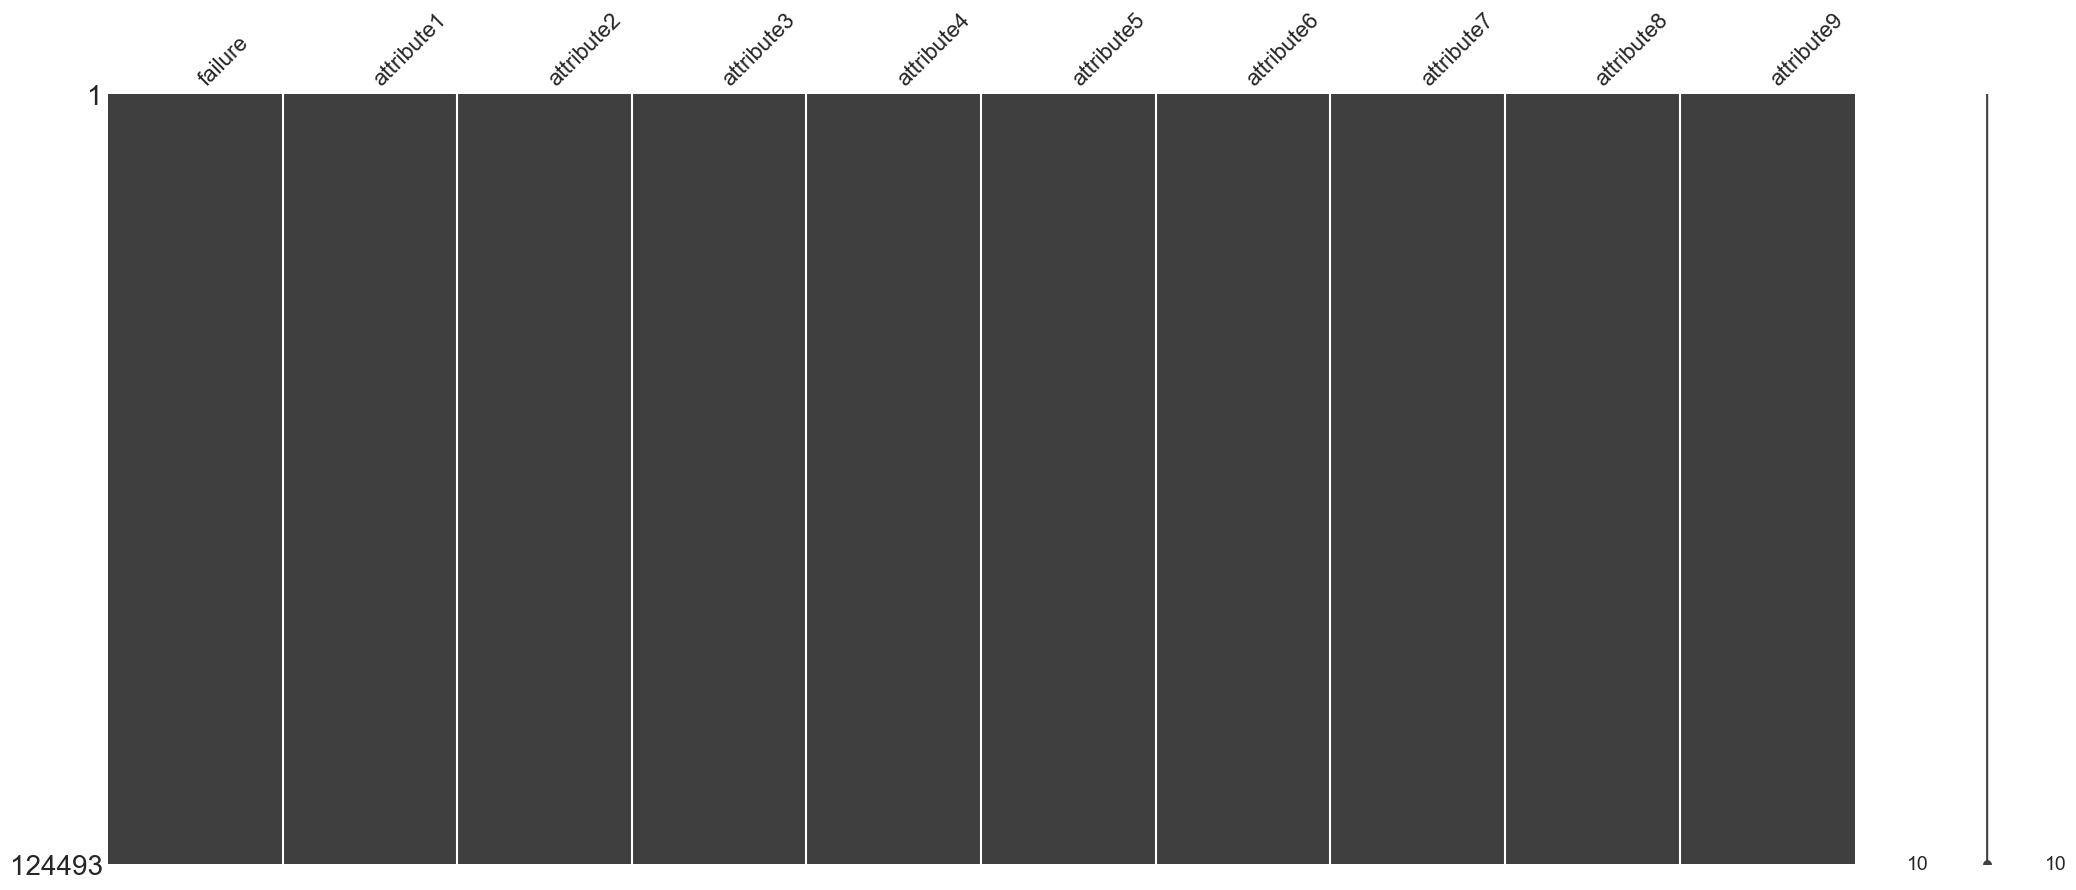

In [22]:
msno.matrix(df)

## Target analysis

- O dataset é extremamente desbalanceado:
    - Apenas 106 exemplos na classe `1`
    - A proporção é de 1173:1

In [23]:
df[df[target]==0].shape[0], df[df[target]==1].shape[0], df[df[target]==0].shape[0] / df[df[target]==1].shape[0]

(124387, 106, 1173.4622641509434)

In [24]:
df[df[target]==1].sample(10)

,,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
device,date,,,,,,,,,,
S1F0GG8X,2015-01-18,1,54292264.0,64736.0,0.0,160.0,11.0,192179.0,0.0,0.0,2.0
Z1F04GCH,2015-02-19,1,37422416.0,976.0,0.0,0.0,13.0,309876.0,48.0,48.0,0.0
S1F0DSTY,2015-02-14,1,97170872.0,2576.0,0.0,60.0,12.0,462175.0,0.0,0.0,0.0
W1F0P114,2015-01-23,1,192865952.0,0.0,0.0,9.0,36.0,271129.0,0.0,0.0,0.0
Z1F14BGY,2015-10-09,1,85259320.0,0.0,0.0,164.0,8.0,262932.0,0.0,0.0,0.0
S1F0CTDN,2015-01-07,1,184069720.0,528.0,0.0,4.0,9.0,387871.0,32.0,32.0,3.0
W1F0FW0S,2015-01-28,1,229400712.0,0.0,0.0,39.0,64.0,200990.0,8.0,8.0,2.0
W1F1CB5E,2015-08-04,1,16043296.0,88.0,0.0,0.0,9.0,30.0,0.0,0.0,0.0
S1F0TQCV,2015-02-18,1,194314640.0,0.0,0.0,0.0,8.0,313659.0,0.0,0.0,1.0


In [25]:
# each device has failed only once
df.groupby("device").sum()[target].sort_values(ascending=False).head()

device
Z1F0LSNZ    1
W1F1230J    1
Z1F0P5D9    1
S1F0L0DW    1
W1F1DQN8    1
Name: failure, dtype: int64

In [26]:
# the failure is the last data point for each device that has failed
df[df[target] == 1].groupby("device").last()[target].sort_values(ascending=True).head()

device
S1F023H2    1
W1F1BS0H    1
W1F1BFP5    1
W1F19BPT    1
W1F15S4D    1
Name: failure, dtype: int64

## Features analysis

Pontos importantes:
- Nenhuma feature possui correlação com o target
- `attribute7` e `attribute8` são identicos, vamos manter apenas um deles

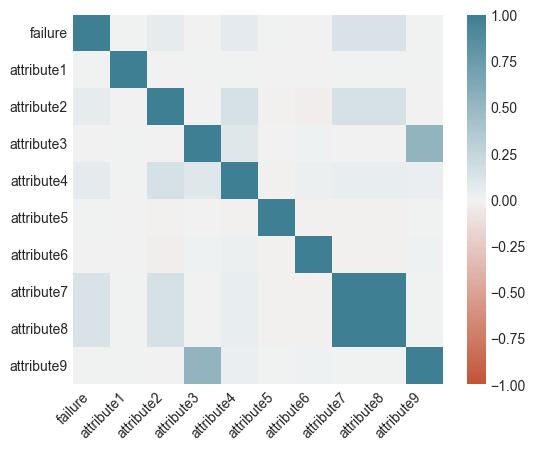

In [27]:
correlation_matrix(df)

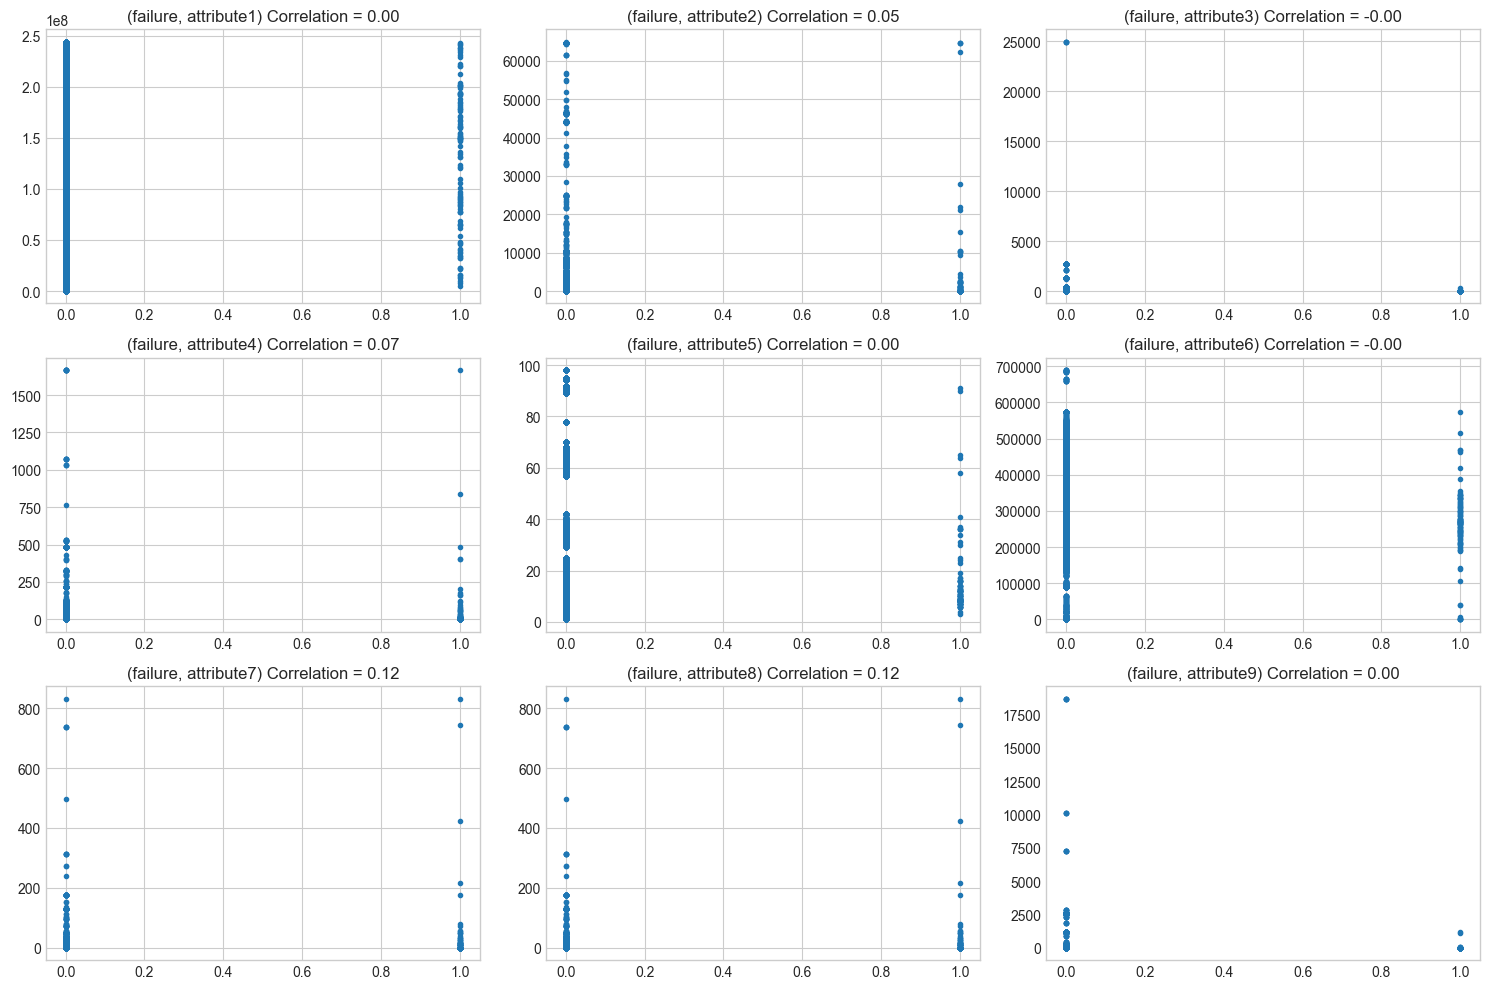

In [28]:
pair_plot_attributes_target(df)

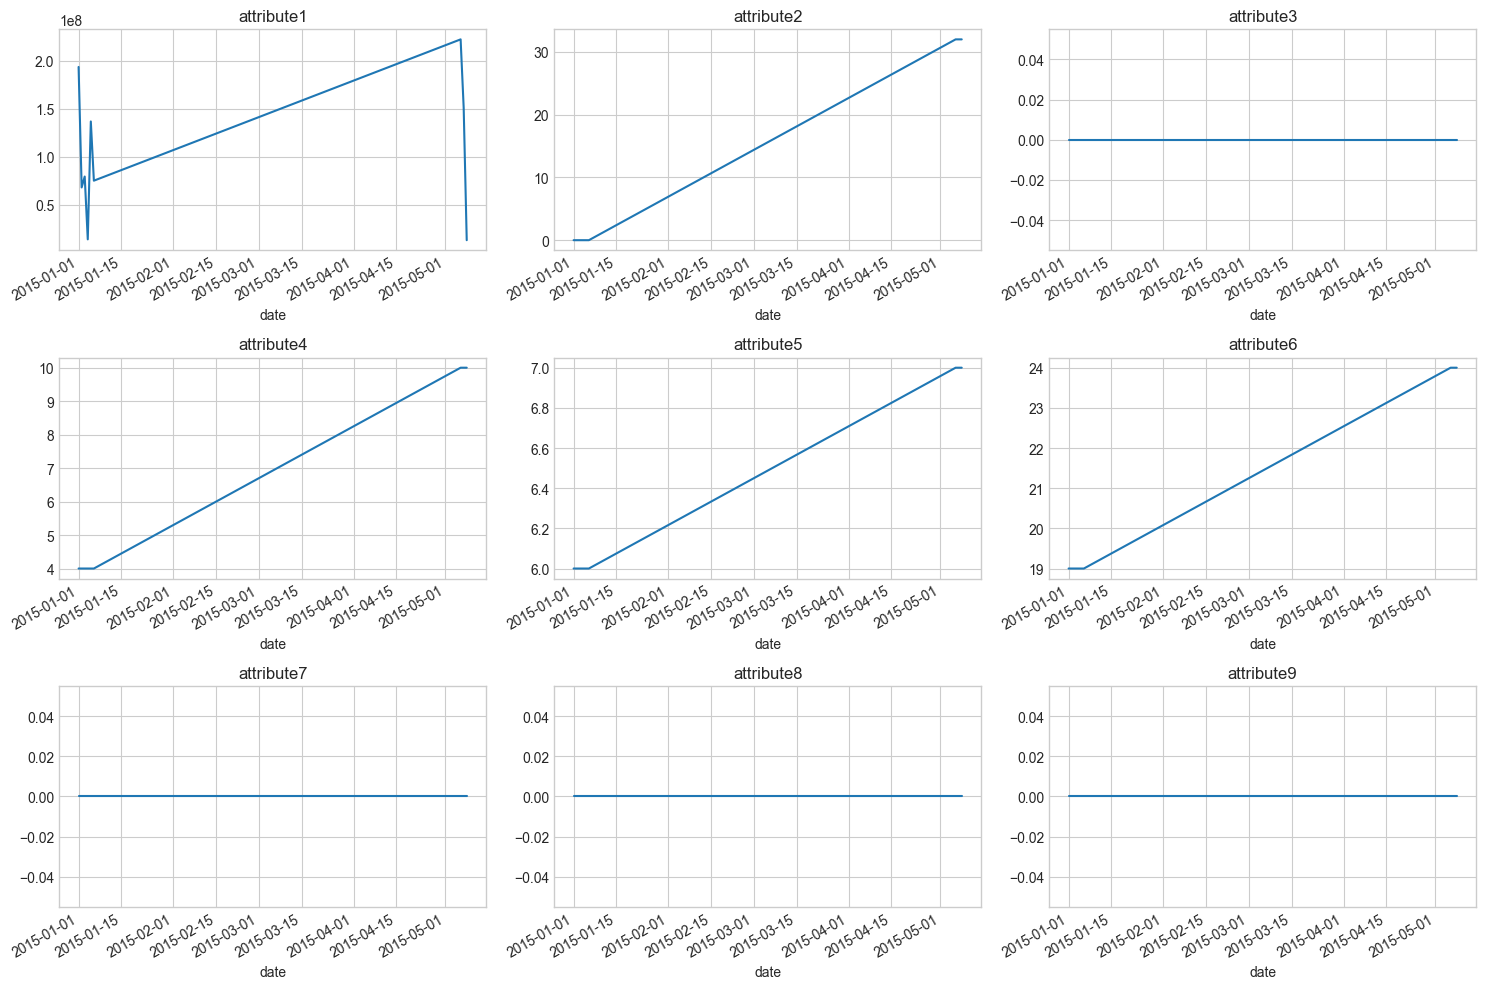

In [29]:
plot_attributes(df, "Z1F1AG5N")

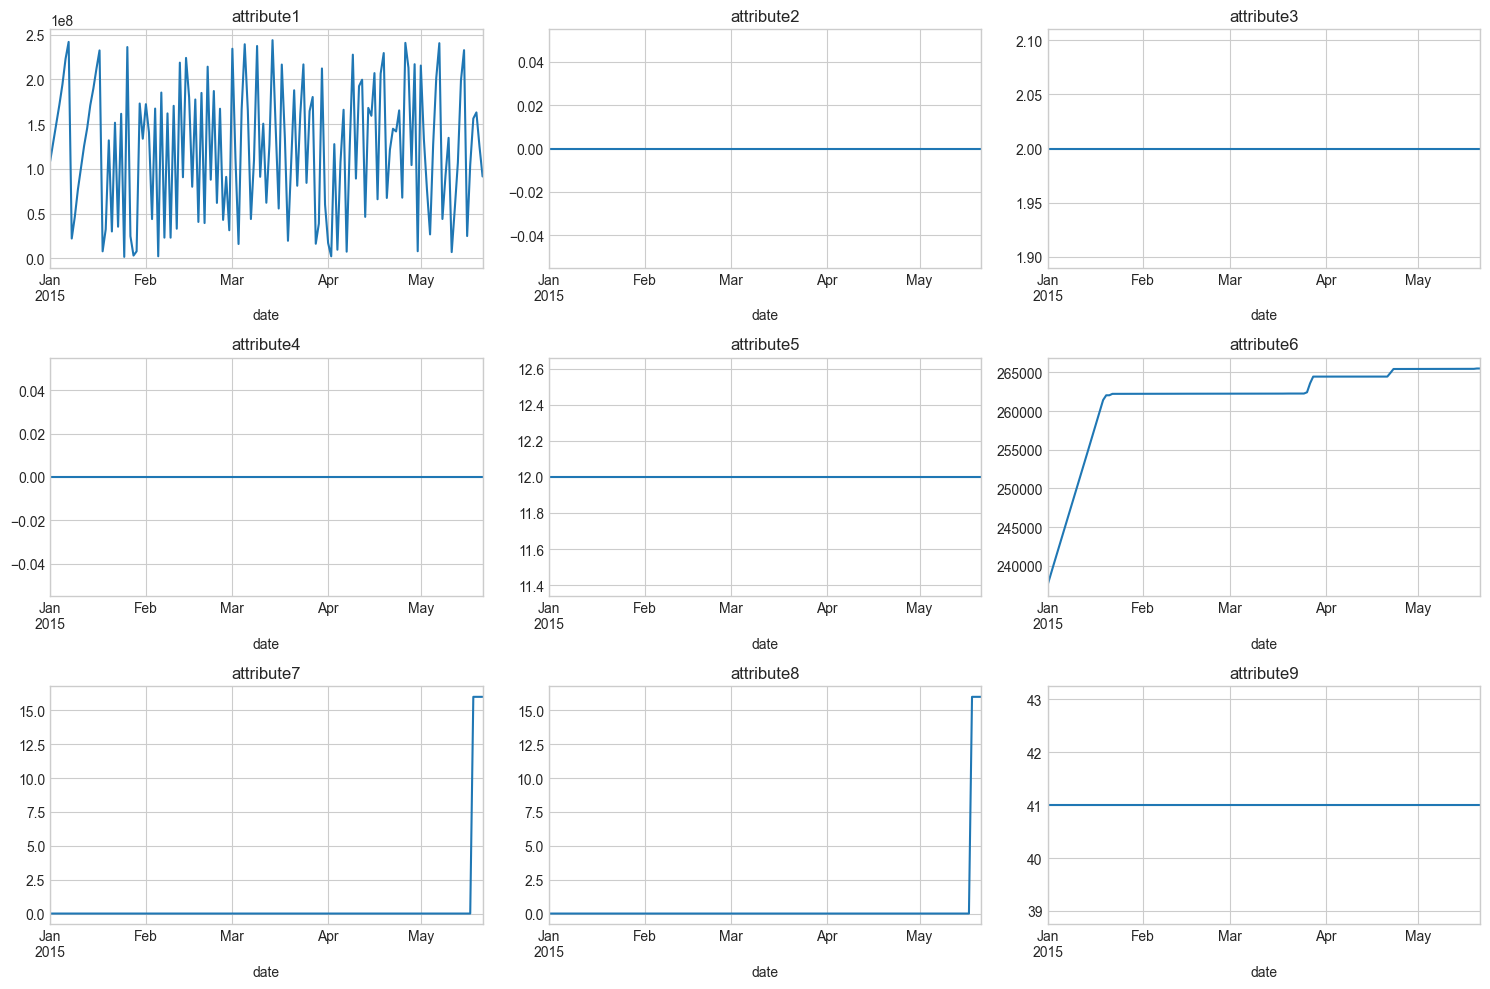

In [30]:
plot_attributes(df, "W1F0WBTM")

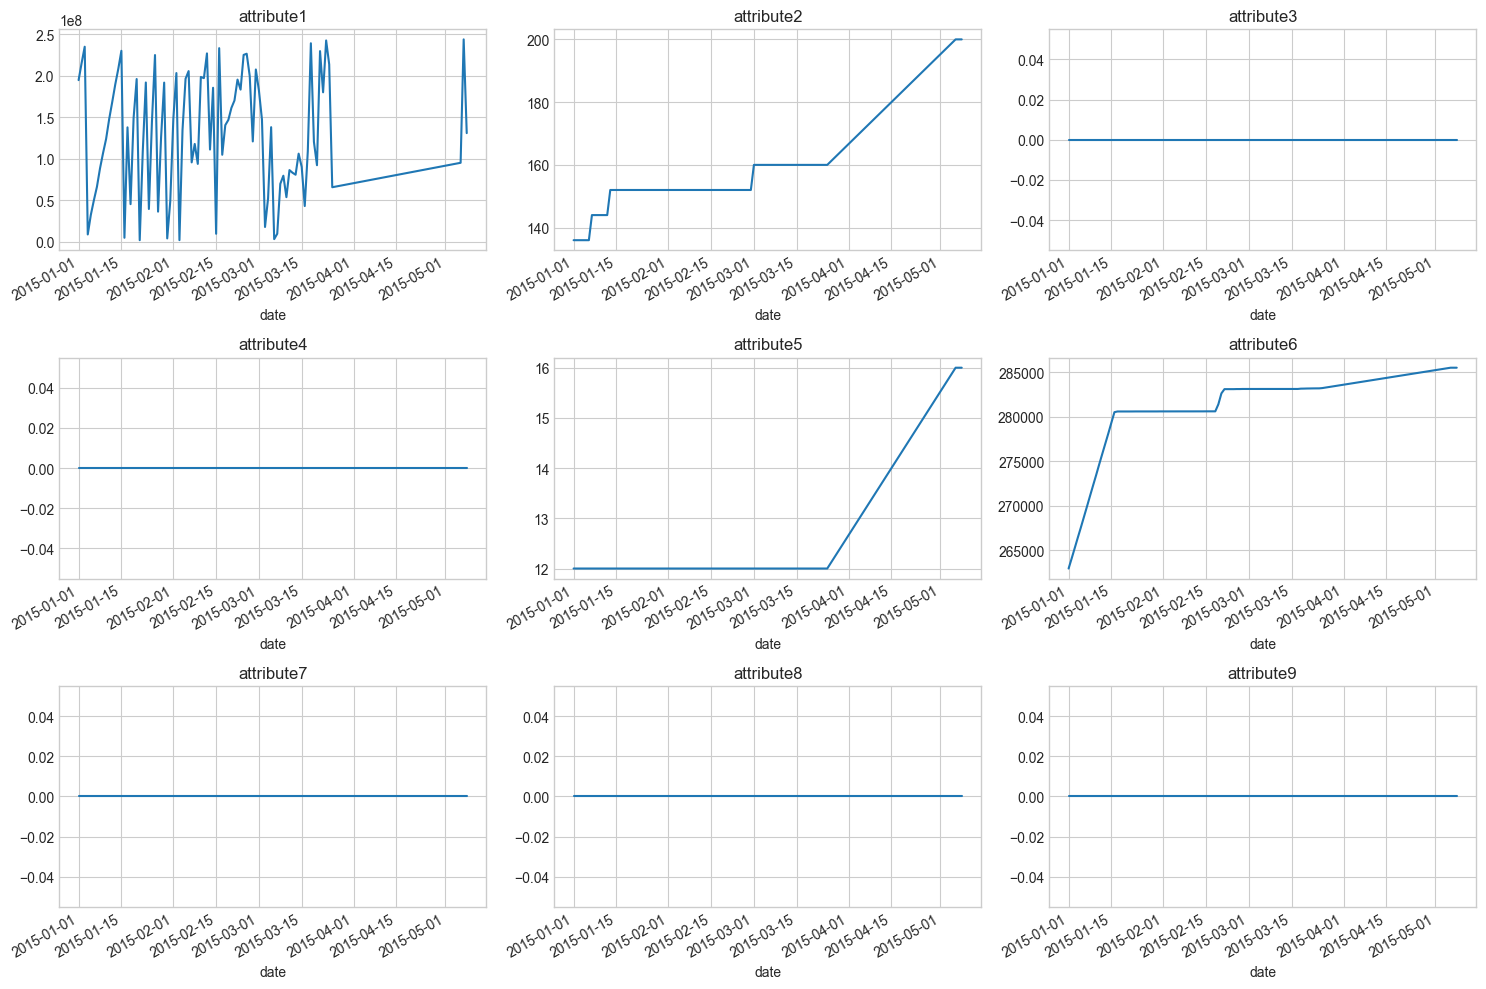

In [31]:
plot_attributes(df, "S1F0RR35")

In [32]:
(df["attribute7"] == df["attribute8"]).sum(), df.shape[0]

(124493, 124493)

In [33]:
df = df.drop("attribute8", axis=1)

## Criando o Modelo

Vamos usar o mlflow para tracking de experimentos. 

Com a configuração atual ele irá criar uma pasta chamda `mlruns` em `notebooks`.
Para acessar sua `UI` basta executar o comando `mlflow ui` dentro da pasta `notebooks` com o virtual environment corretamente ativado.

In [34]:
experiment_name = "failure_prediction"

In [35]:
exps = mlflow.search_experiments(filter_string=f"name = '{experiment_name}'", max_results=1)

In [36]:
if not exps:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = exps[0].experiment_id

### Baseline

Vamos criar um modelo baseline apenas com as features flat já disponibilizadas, utilizando o `XGBClassifier` sem nenhum tipo de tunning nos hyperparâmetros.

Esse modelo sofreu overfitting, nos próximos vamos tratar esse problema

In [37]:
X_train, X_test, y_train, y_test = split_data(df, target, test_size=0.2)

In [38]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_baseline"):
    mlflow.xgboost.autolog()
    xgb_baseline = XGBClassifier(eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_baseline.fit(X_train, y_train, eval_set=eval_set, verbose=False)

2023/02/21 17:18:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/adrianofreitas/prj/meli/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


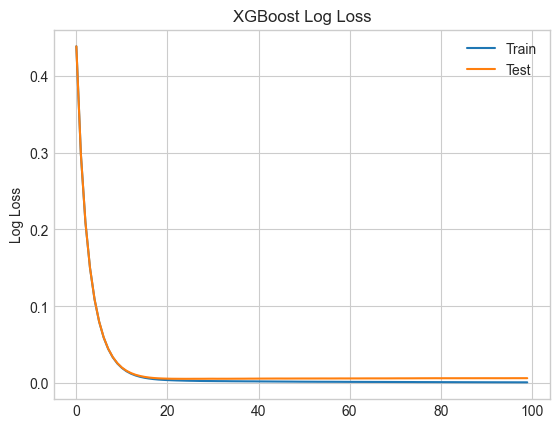

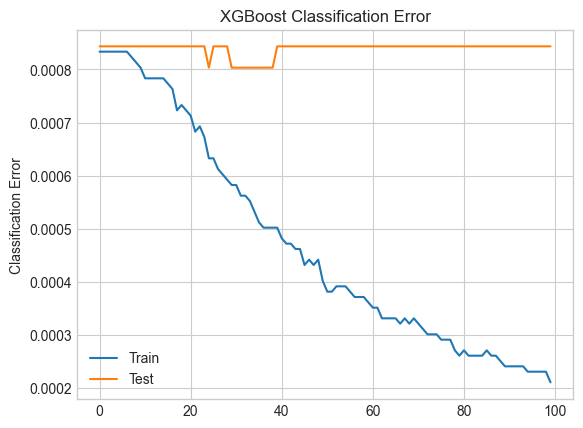

In [39]:
xgb_learning_curves(xgb_baseline)

In [40]:
y_pred_train = xgb_baseline.predict(X_train)
y_pred_test = xgb_baseline.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99509
           1       1.00      0.75      0.86        85

    accuracy                           1.00     99594
   macro avg       1.00      0.88      0.93     99594
weighted avg       1.00      1.00      1.00     99594

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24878
           1       0.00      0.00      0.00        21

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899



/Users/adrianofreitas/prj/meli/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adrianofreitas/prj/meli/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adrianofreitas/prj/meli/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

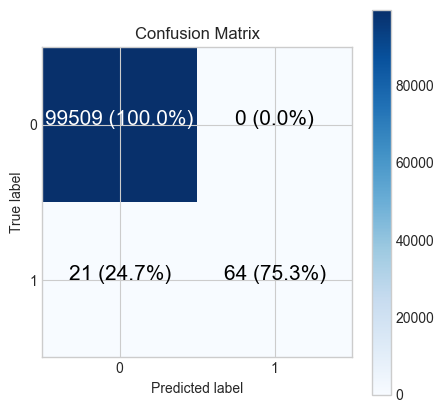

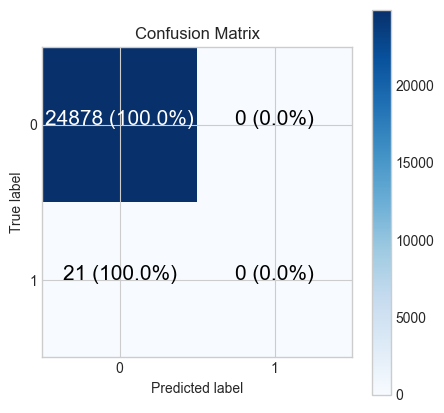

In [41]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

### Feature shifting e Windowing

Vamos criar um shift para que em cada registro conste também os últimos registros da mesma variável.

Vamos criar ainda uma janela onde calcularemos:
- Média
- Desvio padrão
- Menor valor
- Maior valor

Então calcularemos a diferença entre a observação atual e as estatísticas calculadas na janela.

Quanto ao modelo, vamos fazer um tunnig no hyperâmetro `scale_pos_weight`, que fará o modelo penalizar mais os erros na classe `1`, isso irá ajudar com o desbalanceamento.

Com essas modificações, o modelo começou a aprender, ainda que timidamente

In [42]:
# getting window size: the min sequence size
window_size = df.loc[
    df[df[target]==1].index.get_level_values(0).values
].groupby("device").count().min()[target]

In [43]:
cols = [c for c in df.columns if c != target]

X = df.copy()
for col in cols:
    X[f"{col}_min"] = X[col].groupby(level="device").apply(lambda x: x.rolling(window=window_size).min())
    X[f"{col}_diff_min"] = X[col] - X[f"{col}_min"]
    
    X[f"{col}_max"] = X[col].groupby(level="device").apply(lambda x: x.rolling(window=window_size).max())
    X[f"{col}_diff_max"] = X[f"{col}_max"] - X[col]
    
    X[f"{col}_mean"] = X[col].groupby(level="device").apply(lambda x: x.rolling(window=window_size).mean())
    X[f"{col}_diff_mean"] = X[col] - X[f"{col}_mean"]
    
    X[f"{col}_std"] = X[col].groupby(level="device").apply(lambda x: x.rolling(window=window_size).std())
    X[f"{col}_diff_std"] = X[col] - X[f"{col}_std"]
    
    for i in range(1, window_size):
        X[f"{col}_lag{i}"] = X.groupby("device")[col].shift(i)
    X = X.copy()

In [44]:
X = X.dropna()

In [45]:
X.shape

(119821, 105)

In [46]:
new_features = ["attribute1", "attribute1_lag1", "attribute1_lag2", "attribute1_lag3", "attribute1_lag4", 
    "attribute1_mean", "attribute1_diff_mean", "attribute1_std", "attribute1_diff_std", 
    "attribute1_min", "attribute1_diff_min", "attribute1_max", "attribute1_diff_max"]

In [47]:
X.loc[["S1F0RRB1", "S1F0CTDN", "W1F0PNA5"]][[target]+new_features]

failure   attribute1  attribute1_lag1  attribute1_lag2  \
device   date                                                                 
S1F0RRB1 2015-01-05        1   48467332.0       37985862.0       26258330.0   
S1F0CTDN 2015-01-05        0  134261688.0      112311608.0       91492168.0   
         2015-01-06        0  159974064.0      134261688.0      112311608.0   
         2015-01-07        1  184069720.0      159974064.0      134261688.0   
W1F0PNA5 2015-01-05        0   38285364.0       14442703.0      234878700.0   
         2015-01-06        0   65311277.0       38285364.0       14442703.0   
         2015-01-07        0   88355682.0       65311277.0       38285364.0   
         2015-01-08        0  111562891.0       88355682.0       65311277.0   
         2015-01-09        1  136429411.0      111562891.0       88355682.0   

                     attribute1_lag3  attribute1_lag4  attribute1_mean  \
device   date                                                            
S1F0RRB1 2015-01-05       13307628.0        5230888.0       26250008.0   
S1F0CTDN 2015-01-05       72104024.0       50147888.0       92063475.2   
         2015-01-06       91492168.0       72104024.0      114028710.4   
         2015-01-07      112311608.0       91492168.0      136421849.6   
W1F0PNA5 2015-01-05      211326211.0      185403491.0      136867293.8   
         2015-01-06      234878700.0      211326211.0      112848851.0   
         2015-01-07       14442703.0      234878700.0       88254745.2   
         2015-01-08       38285364.0       14442703.0       63591583.4   
         2015-01-09       65311277.0       38285364.0       87988925.0   

                     attribute1_diff_mean  attribute1_std  \
device   date                                               
S1F0RRB1 2015-01-05            22217324.0    1.761142e+07   
S1F0CTDN 2015-01-05            42198212.8    3.296323e+07   
         2015-01-06            45945353.6    3.460084e+07   
         2015-01-07            47647870.4    3.684316e+07   
W1F0PNA5 2015-01-05           -98581929.8    1.027282e+08   
         2015-01-06           -47537574.0    1.025821e+08   
         2015-01-07              100936.8    8.655945e+07   
         2015-01-08            47971307.6    3.864415e+07   
         2015-01-09            48440486.0    3.836361e+07   

                     attribute1_diff_std  attribute1_min  attribute1_diff_min  \
device   date                                                                   
S1F0RRB1 2015-01-05         3.085591e+07       5230888.0           43236444.0   
S1F0CTDN 2015-01-05         1.012985e+08      50147888.0           84113800.0   
         2015-01-06         1.253732e+08      72104024.0           87870040.0   
         2015-01-07         1.472266e+08      91492168.0           92577552.0   
W1F0PNA5 2015-01-05        -6.444280e+07      14442703.0           23842661.0   
         2015-01-06        -3.727086e+07      14442703.0           50868574.0   
         2015-01-07         1.796232e+06      14442703.0           73912979.0   
         2015-01-08         7.291874e+07      14442703.0           97120188.0   
         2015-01-09         9.806580e+07      38285364.0           98144047.0   

                     attribute1_max  attribute1_diff_max  
device   date                                             
S1F0RRB1 2015-01-05      48467332.0                  0.0  
S1F0CTDN 2015-01-05     134261688.0                  0.0  
         2015-01-06     159974064.0                  0.0  
         2015-01-07     184069720.0                  0.0  
W1F0PNA5 2015-01-05     234878700.0          196593336.0  
         2015-01-06     234878700.0          169567423.0  
         2015-01-07     234878700.0          146523018.0  
         2015-01-08     111562891.0                  0.0  
         2015-01-09     136429411.0                  0.0

In [53]:
# split data based on device ids
X_train, X_test, y_train, y_test = split_data_on_index(X, target, index_level=0)

In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
# finding best value for scale_pos_weight, it should be equal to the proportion of the classes
counter = Counter(X[target])
scale_pos_weight = round(counter[0] / counter[1], 0)

print(counter[0], counter[1], scale_pos_weight)

119715 106 1129.0


In [58]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_4_lags"):
    mlflow.xgboost.autolog()
    xgb_lags = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_lags.fit(X_train, y_train, eval_set=eval_set, verbose=False)

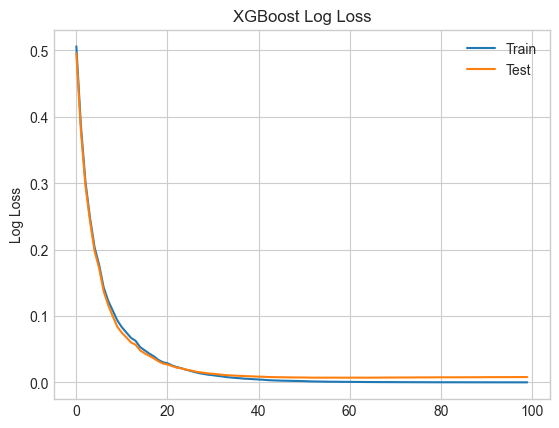

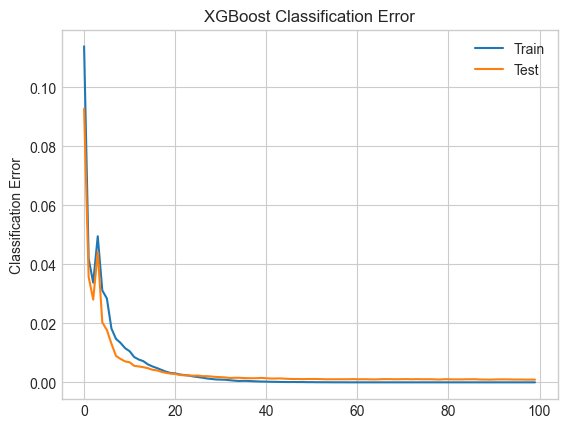

In [59]:
xgb_learning_curves(xgb_lags)

In [60]:
y_pred_train = xgb_lags.predict(X_train)
y_pred_test = xgb_lags.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     95769
           1       1.00      1.00      1.00        87

    accuracy                           1.00     95856
   macro avg       1.00      1.00      1.00     95856
weighted avg       1.00      1.00      1.00     95856

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23946
           1       0.20      0.05      0.08        19

    accuracy                           1.00     23965
   macro avg       0.60      0.53      0.54     23965
weighted avg       1.00      1.00      1.00     23965



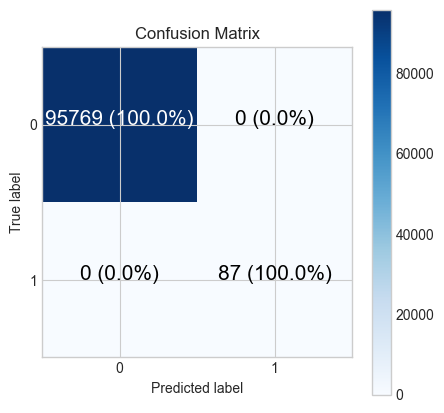

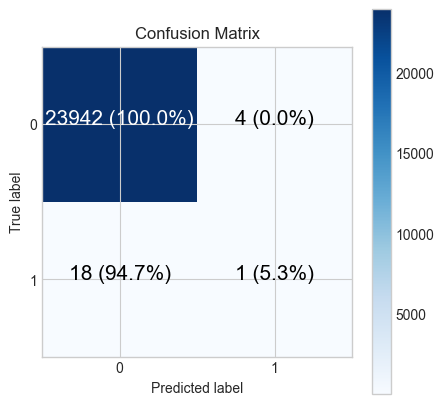

In [61]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

### Otimizando alguns hiperparâmetros

Conseguimos melhorar o `recall` no dataset de treino, mas ao custo de muitos falsos positivos. Esse não é o melhor cenário uma vez que esses equipamentos seriam enviados para a manutenção que também possui um custo (ainda que o custo da falha)

In [70]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_hyper_tune"):
    mlflow.xgboost.autolog()
    xgb = XGBClassifier(
        seed=0,
        scale_pos_weight=scale_pos_weight,
        colsample_bytree=0.4,
        subsample=0.9,
        max_depth=3,
        gamma=6,
        n_estimators=750,
        learning_rate=0.001,
        eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

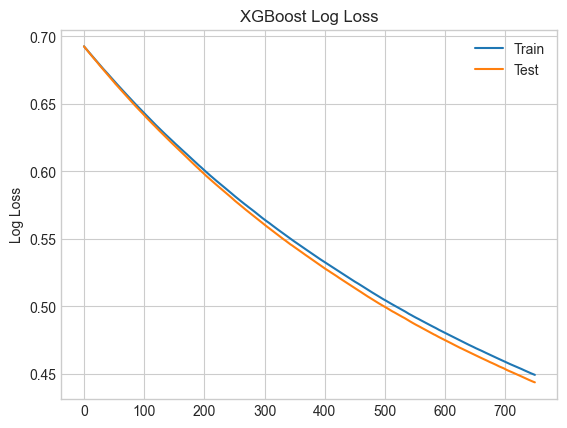

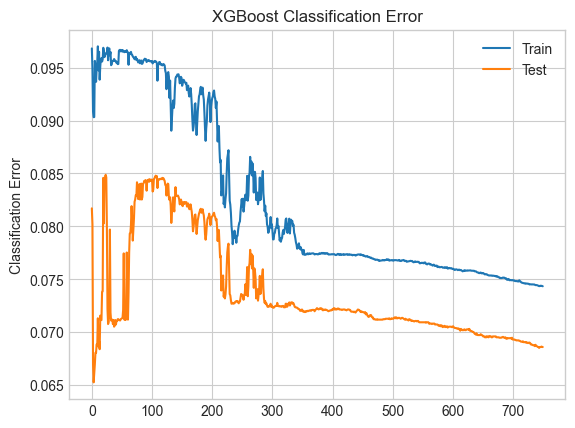

In [71]:
xgb_learning_curves(xgb)

In [72]:
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     95769
           1       0.01      0.82      0.02        87

    accuracy                           0.93     95856
   macro avg       0.50      0.87      0.49     95856
weighted avg       1.00      0.93      0.96     95856

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     23946
           1       0.01      0.63      0.01        19

    accuracy                           0.93     23965
   macro avg       0.50      0.78      0.49     23965
weighted avg       1.00      0.93      0.96     23965



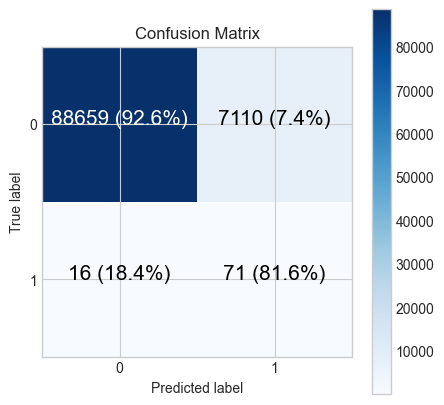

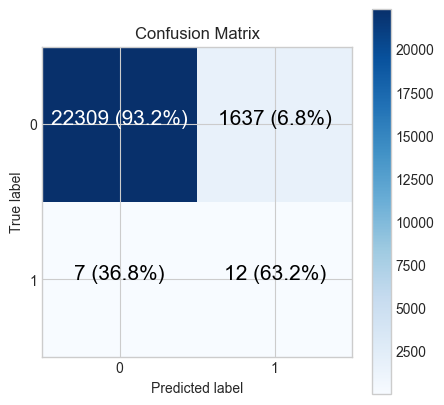

In [73]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

In [74]:
print(f"""
Custo baseado nos dados de teste: 
    Manutenção: {1637 * 0.5}
    Falha: 7
    Total: {(1637 * 0.5) + 7}
""")


Custo baseado nos dados de teste: 
    Manutenção: 818.5
    Falha: 7
    Total: 825.5



### Encontrando os melhores Hyperparâmetros

Vamos utilizar a lib Hyperopt para realizar um tunning nos hyperparâmetros. Ela utiliza uma abosdagem bayesiana e não fará grid search, economizando assim tempo na busca dos melhores valores.

Na função objetivo utilizei o `f1-score` como métrica. A ideia de utilizar o `f1-score` foi para tentar reduzir os falsos positivos sem uma grande perda no `recall`. 

Considerando o custo de manutenção e falhas, esse modelo teve uma performance melhor que o anterior, ainda que não seja satisfatória.

In [63]:
space = {
    'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.1, 0.3]),
    'max_depth' : hp.choice('max_depth', range(3,7)),
    'gamma' : hp.choice('gamma', [2,4,6]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
    'subsample' : hp.choice('subsample', [i/10.0 for i in range(3,10)]),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 50))
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [64]:
# Objective function
def objective(params):
    xgboost = XGBClassifier(seed=0, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train, 
                            y=y_train, 
                            cv=kfold, 
                            scoring='f1', 
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [77]:
%%time
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_hyperopt"):
    mlflow.xgboost.autolog()

    # Optimize
    best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = Trials())
    
    # Train model using the best parameters
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_lags_opt = XGBClassifier(seed=0, 
                                 scale_pos_weight=scale_pos_weight,
                                 learning_rate=space_eval(space, best)['learning_rate'], 
                                 max_depth=space_eval(space, best)['max_depth'],
                                 gamma=space_eval(space, best)['gamma'], 
                                 colsample_bytree=space_eval(space, best)['colsample_bytree'], 
                                 subsample=space_eval(space, best)['subsample'], 
                                 eval_metric=['error', 'logloss']
                                ).fit(X_train,y_train, eval_set=eval_set, verbose=False)

{'colsample_bytree': 6, 'gamma': 2, 'learning_rate': 2, 'max_depth': 1, 'n_estimators': 14, 'subsample': 1}
{'colsample_bytree': 0.9, 'gamma': 6, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.4}
CPU times: user 44.4 s, sys: 704 ms, total: 45.2 s
Wall time: 32 s


In [ ]:
space_eval(space, best)

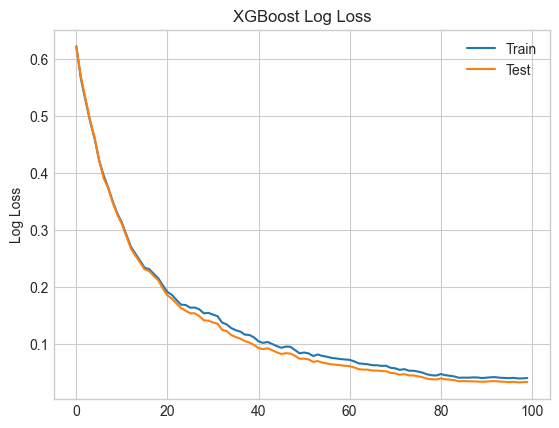

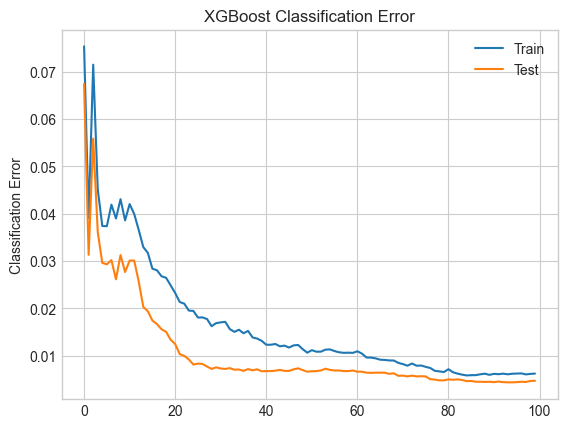

In [67]:
xgb_learning_curves(xgb_lags_opt)

In [68]:
y_pred_train = xgb_lags_opt.predict(X_train)
y_pred_test = xgb_lags_opt.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     95769
           1       0.13      1.00      0.23        87

    accuracy                           0.99     95856
   macro avg       0.56      1.00      0.61     95856
weighted avg       1.00      0.99      1.00     95856

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23946
           1       0.04      0.21      0.07        19

    accuracy                           1.00     23965
   macro avg       0.52      0.60      0.53     23965
weighted avg       1.00      1.00      1.00     23965



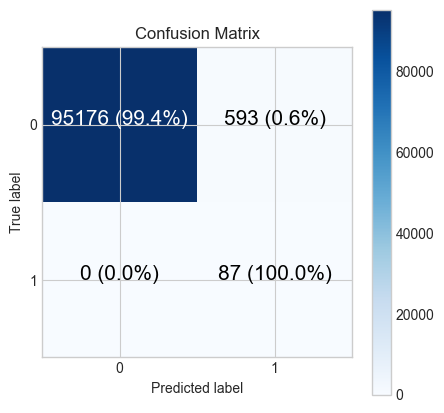

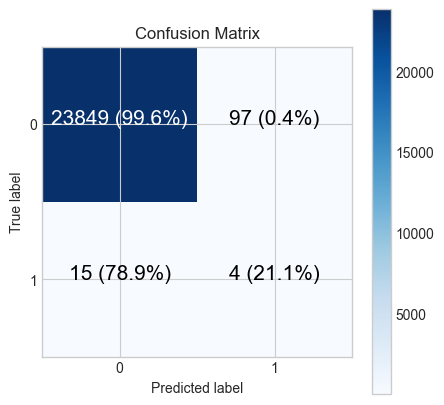

In [69]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

In [75]:
print(f"""
Custo baseado nos dados de teste: 
    Manutenção: {97 * 0.5}
    Falha: 15
    Total: {(97 * 0.5) + 17}
""")


Custo baseado nos dados de teste: 
    Manutenção: 48.5
    Falha: 15
    Total: 65.5



## Interpretando o Modelo

Olhando para o summary_plot podemos observar:
- A feature calculada `attribute4_diff_std` fez um trabalho razoável separando as classes
- O mesmo pode-se dizer da feature `attribute1_lag1`
- Muitas features não conseguiram contribuir muito para a separação das classes, isso explica a performance não tão boa do modelo.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


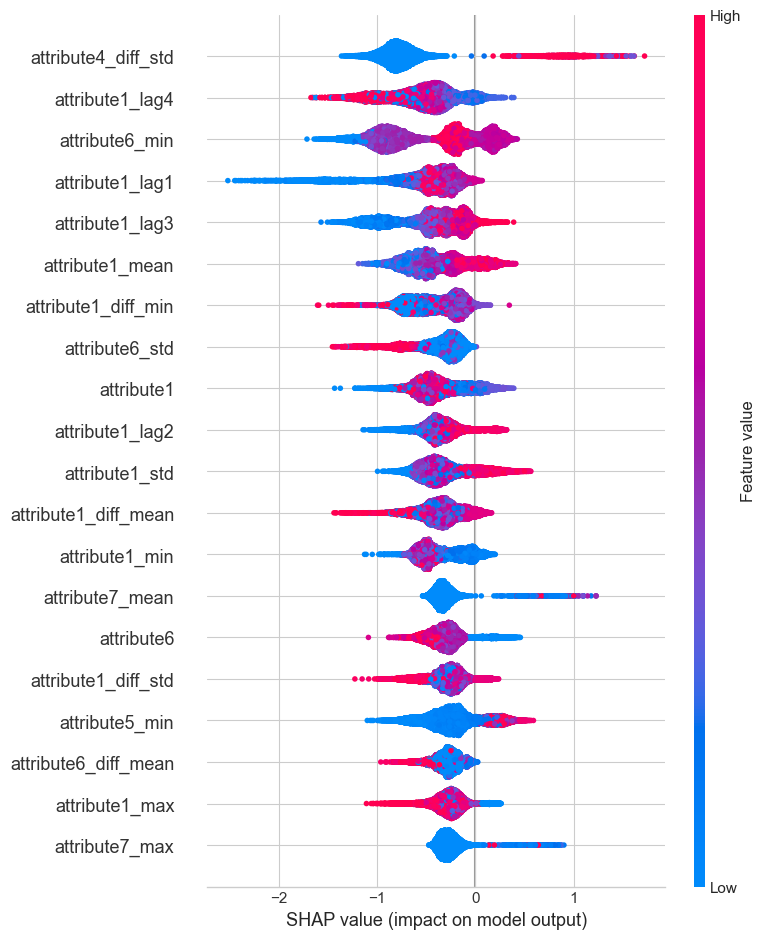

In [127]:
shap_explain(xgb_lags_opt, X_test, list(X.drop(target, axis=1).columns))

## Considerações futuras

Como opções para melhorar a performance do modelo, podemos considerar
- Oversampling da classe minoritaria, combinado ou não com undersampling da classe maioritária
- Outros tipos de modelo, incluindo redes neurais
    - Comecei uma versão de LSTM mas não terminei a tempo